In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import random
import torch
import re

%matplotlib inline

In [2]:
model_id = 'microsoft/Florence-2-large'
device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

c:\Users\stopc\anaconda3\envs\transformers-env\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
def filter_and_relabel(image, bboxes, labels):
    filtered_bboxes = []
    filtered_labels = []
    img_width, img_height = image.size

    # Define exact keywords using regex with word boundaries
    pet_keywords = re.compile(r'\b(dog|cat)\b', re.IGNORECASE)
    person_keywords = re.compile(r'\b(person|man|woman|boy|girl|child|kid)\b', re.IGNORECASE)

    for bbox, label in zip(bboxes, labels):
        # Match exact keywords
        if pet_keywords.search(label):
            label = "pet"
        elif person_keywords.search(label):
            label = "person"
        else:
            continue  # Skip irrelevant labels

        # Compute bounding box area
        x1, y1, x2, y2 = bbox
        bbox_area = (x2 - x1) * (y2 - y1)
        img_area = img_width * img_height

        # Filter by bounding box size (area between 5% and 95% of image area)
        if not (0.05 * img_area <= bbox_area <= 0.95 * img_area):
            continue

        # Add filtered results
        filtered_bboxes.append([x1, y1, x2, y2])
        filtered_labels.append(label)

    return filtered_bboxes, filtered_labels

def plot_bbox(image, data):
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    ax.axis('off')
    plt.show()

# Runs a specific task using Florence-2
def perform_florence_task(task_prompt, image):
    # Prepare inputs for the model
    inputs = processor(text=task_prompt, images=image, return_tensors="pt").to(device, torch.float16)

    # Run the model to generate predictions
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )

    # Decode and process the model's output
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer


In [4]:
flickr_dataset_path = "flickr30k_images"  
image_paths = [str(path) for path in Path(flickr_dataset_path).rglob('*.jpg')]

# Verify the dataset and load a sample image
if len(image_paths) == 0:
    print("No JPG images found in the specified path.")
else:
    print(f"Found {len(image_paths)} JPG images in the dataset.")

Found 31783 JPG images in the dataset.


In [5]:
# Load the CSV file
csv_path = "flickr30k_descriptions.csv"
caption = pd.read_csv(csv_path, sep=r'\|\s*', engine='python', encoding='utf-8')

# Convert 'comment' column to strings
caption['comment'] = caption['comment'].astype(str)

# Group comments by image_name and combine them into a single string
caption = caption.groupby('image_name')['comment'].apply(lambda x: ' '.join(map(str, x))).reset_index()

# Function to filter images based on inclusion and exclusion criteria
def filter_and_label_images(caption, inclusion_keywords, exclusion_keywords=None, label=None):
    # Pre-compile regex patterns
    inclusion_patterns = [re.compile(rf'\b{keyword}\b', re.IGNORECASE) for keyword in inclusion_keywords]
    exclusion_patterns = (
        [re.compile(rf'\b{keyword}\b', re.IGNORECASE) for keyword in exclusion_keywords]
        if exclusion_keywords else []
    )

    labeled_images = []

    # Iterate through caption
    for _, row in caption.iterrows():
        image_name = row['image_name']  # Image filename
        combined_comments = row['comment']  # Combined comments for the image

        # Check inclusion and exclusion criteria
        contains_inclusion_keywords = any(pattern.search(combined_comments) for pattern in inclusion_patterns)
        contains_exclusion_keywords = any(pattern.search(combined_comments) for pattern in exclusion_patterns)

        if contains_inclusion_keywords and not contains_exclusion_keywords:
            labeled_images.append({'image_name': image_name, 'label': label})

    return pd.DataFrame(labeled_images)

# Filter and label images
cat_images = filter_and_label_images(caption, inclusion_keywords=['cat'], label='cat')
dog_images = filter_and_label_images(caption, inclusion_keywords=['dog'], label='dog')
person_images = filter_and_label_images(
    caption,
    inclusion_keywords=[
        'face', 'posing', 'smile'
    ],
    exclusion_keywords=[
        'four', 'five', 'six', 'seven', 
        'eight', 'nine', 'surrounded', 
        'many', 'several', 'crowd', 
        'team', 'group', 'gathering', 
        'audience', 'mob', 'parade', 
        'spectators', 'fans'
    ],
    label='person'
)

# Combine all labeled images into a single DataFrame
all_labeled_images = pd.concat([cat_images, dog_images, person_images], ignore_index=True)

# Save the combined results to a single CSV file
all_labeled_images.to_csv("labeled_images.csv", index=False)

# Print summary
print(f"Relevant images identified for cats: {len(cat_images)}")
print(f"Relevant images identified for dogs: {len(dog_images)}")
print(f"Relevant images identified for persons excluding large groups: {len(person_images)}")
print(f"Saved all labeled images to 'labeled_images.csv'.")

Relevant images identified for cats: 74
Relevant images identified for dogs: 2095
Relevant images identified for persons excluding large groups: 1586
Saved all labeled images to 'labeled_images.csv'.


Processing images using <OD> with filters...
Visualizing filtered results for image: 4863999220.jpg


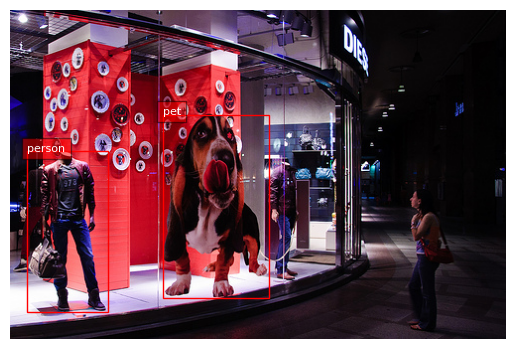

Visualizing filtered results for image: 3400385314.jpg


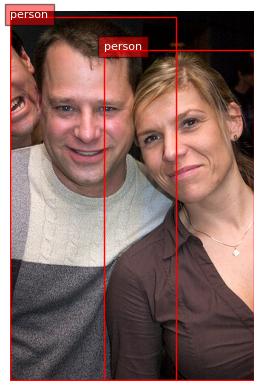

Visualizing filtered results for image: 1601358043.jpg


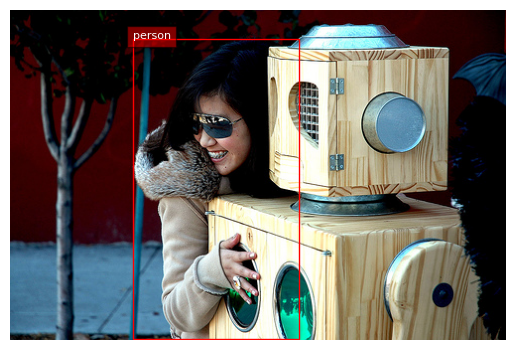

Visualizing filtered results for image: 3626475209.jpg


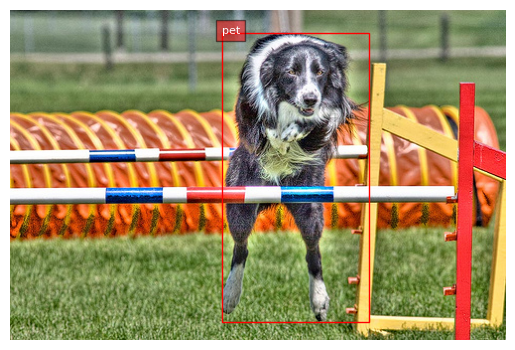

In [12]:
# Load filtered image names from CSV
images = pd.read_csv("labeled_images.csv")['image_name'].tolist()

# sample_images = images[:3]  # Select images for visualization
sample_images = random.sample(images, 4)  # Randomly sample images

print("Processing images using <OD> with filters...")

for img_name in sample_images:
    try:
        # Load the image
        image_path = f"flickr30k_images/{img_name}"  # Adjust to your dataset path
        image = Image.open(image_path).convert('RGB')
        
        # Perform Object Detection
        task_prompt = '<OD>'
        od_results = perform_florence_task(task_prompt, image)
        
        # Extract bounding boxes and labels
        bboxes = od_results['<OD>']['bboxes']
        labels = od_results['<OD>']['labels']
        
        # Filter and relabel the results
        filtered_bboxes, filtered_labels = filter_and_relabel(image, bboxes, labels)
        
        # Combine filtered results for visualization
        filtered_results = {'bboxes': filtered_bboxes, 'labels': filtered_labels}
        
        # Visualize the bounding boxes on the image
        if filtered_bboxes:
            print(f"Visualizing filtered results for image: {img_name}")
            plot_bbox(image, filtered_results)
        else:
            print(f"No relevant objects found in image: {img_name}")

    except Exception as e:
        print(f"Error processing image {img_name}: {e}")


In [7]:
# Load images with labels
images = pd.read_csv("labeled_images.csv")

# Separate images by their labels
cat_images = images[images['label'] == 'cat']['image_name'].tolist()
dog_images = images[images['label'] == 'dog']['image_name'].tolist()
person_images = images[images['label'] == 'person']['image_name'].tolist()

# Combine pet images (all cats + first 800 dogs)
selected_pet_images = cat_images + dog_images[:800]
selected_person_images = person_images[:800]  # First 800 person images

# Combine all selected images for processing
selected_images = selected_pet_images + selected_person_images

# Initialize counters and dictionaries
all_pet_detections = []
all_person_detections = []
dominant_image_labels = {}  # Maps each image to its assigned dominant label

print("Processing images using <OD> with filters...")

for img_name in tqdm(selected_images, desc="Filtering images", unit="image"):
    try:
        # Load the image
        image_path = f"flickr30k_images/{img_name}"  # Adjust to your dataset path
        image = Image.open(image_path).convert('RGB')
        
        # Perform Object Detection
        task_prompt = '<OD>'
        od_results = perform_florence_task(task_prompt, image)
        
        # Extract bounding boxes and labels
        bboxes = od_results['<OD>']['bboxes']
        labels = od_results['<OD>']['labels']
        
        # Filter and relabel the results
        filtered_bboxes, filtered_labels = filter_and_relabel(image, bboxes, labels)
        
        # Track all detections for counting
        for label in filtered_labels:
            if label == "pet":
                all_pet_detections.append(img_name)
            elif label == "person":
                all_person_detections.append(img_name)
        
        # Assign dominant label to each image
        if "pet" in filtered_labels:
            dominant_image_labels[img_name] = "pet"  # Pet has higher priority
        elif "person" in filtered_labels and img_name not in dominant_image_labels:
            dominant_image_labels[img_name] = "person"

    except Exception as e:
        print(f"Error processing image {img_name}: {e}")

# Save processed images with dominant labels to CSV
output_data = pd.DataFrame({
    'image_name': dominant_image_labels.keys(),
    'label': dominant_image_labels.values()
})
output_data.to_csv("final_labeled_images.csv", index=False)

# Print detailed counts
print(f"Total detected pet objects: {len(all_pet_detections)}")
print(f"Total detected person objects: {len(all_person_detections)}")
print(f"Number of images labeled as 'pet': {list(dominant_image_labels.values()).count('pet')}")
print(f"Number of images labeled as 'person': {list(dominant_image_labels.values()).count('person')}")
print(f"Saved processed image labels to 'final_labeled_images.csv'.")

Processing images using <OD> with filters...


Filtering images: 100%|██████████| 1674/1674 [34:09<00:00,  1.22s/image]

Total detected pet objects: 960
Total detected person objects: 1610
Number of images labeled as 'pet': 746
Number of images labeled as 'person': 776
Saved processed image labels to 'final_labeled_images.csv'.


In [ ]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image

# Define YOLO dataset structure
base_path = "datasets/flickr"
folders = {
    "train": {
        "images": os.path.join(base_path, "images/train"),
        "labels": os.path.join(base_path, "labels/train"),
    },
    "val": {
        "images": os.path.join(base_path, "images/val"),
        "labels": os.path.join(base_path, "labels/val"),
    },
    "test": {
        "images": os.path.join(base_path, "images/test"),
        "labels": os.path.join(base_path, "labels/test"),
    }
}

# Create directories if they do not exist
for split in folders:
    os.makedirs(folders[split]["images"], exist_ok=True)
    os.makedirs(folders[split]["labels"], exist_ok=True)

# Load the labeled dataset
labeled_data = pd.read_csv("final_labeled_images.csv")
pet_images = labeled_data[labeled_data["label"] == "pet"][:700]
person_images = labeled_data[labeled_data["label"] == "person"][:700]

# Split images into train (80%), val (10%), test (10%)
train_pets = pet_images[:560]
val_pets = pet_images[560:630]
test_pets = pet_images[630:]

train_persons = person_images[:560]
val_persons = person_images[560:630]
test_persons = person_images[630:]

splits = {
    "train": pd.concat([train_pets, train_persons], ignore_index=True),
    "val": pd.concat([val_pets, val_persons], ignore_index=True),
    "test": pd.concat([test_pets, test_persons], ignore_index=True),
}

# Normalize bounding box coordinates
def normalize_bbox(bbox, img_w, img_h):
    x1, y1, x2, y2 = bbox
    w = x2 - x1
    h = y2 - y1
    x_center = x1 + (w / 2)
    y_center = y1 + (h / 2)
    return x_center / img_w, y_center / img_h, w / img_w, h / img_h

# Class mapping
class_mapping = {"person": 0, "pet": 1}

# Function to process and save images and labels in YOLO format
def process_and_save_data(split_name, split_images):
    for _, row in tqdm(split_images.iterrows(), desc=f"Processing {split_name}", total=len(split_images)):
        try:
            img_name = row["image_name"]
            label = row["label"]
            class_id = class_mapping[label]
            
            # Load image
            image_path = f"flickr30k_images/{img_name}"  # Change path if needed
            image = Image.open(image_path).convert("RGB")
            img_width, img_height = image.size
            
            # Perform Object Detection using Florence-2
            task_prompt = "<OD>"
            od_results = perform_florence_task(task_prompt, image)
            bboxes = od_results["<OD>"]["bboxes"]
            labels = od_results["<OD>"]["labels"]
            
            # Filter and normalize bounding boxes
            filtered_bboxes, filtered_labels = filter_and_relabel(image, bboxes, labels)
            yolo_labels = []
            for bbox, lbl in zip(filtered_bboxes, filtered_labels):
                if lbl in class_mapping:  # Only process relevant classes
                    x_center, y_center, bbox_width, bbox_height = normalize_bbox(bbox, img_width, img_height)
                    yolo_labels.append(f"{class_mapping[lbl]} {x_center} {y_center} {bbox_width} {bbox_height}")
            
            # Save image and label
            if yolo_labels:
                split_folder = folders[split_name]

                # Save image in the correct directory
                image.save(os.path.join(split_folder["images"], img_name))

                # Save label file in YOLO format
                label_file_path = os.path.join(split_folder["labels"], img_name.replace(".jpg", ".txt"))
                with open(label_file_path, "w") as label_file:
                    label_file.write("\n".join(yolo_labels))

        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

# Process each dataset split
for split_name, split_images in splits.items():
    process_and_save_data(split_name, split_images)

print("Dataset successfully converted to Ultralytics YOLO format!")


Processing test: 100%|██████████| 140/140 [03:26<00:00,  1.48s/it]


Dataset successfully converted to Ultralytics YOLO format!
